In [1]:
import geopandas as gpd
import pandas as pd
import mercantile
import requests
from vt2geojson.tools import vt_bytes_to_geojson
from shapely.geometry import shape
from tqdm import tqdm
import osmnx as ox
import os
import matplotlib.pyplot as plt
import numpy as np
import mapclassify as mc

## Notice

As querying processes require a Mapillary token, are time intensive, and are subject to change over tiem, I have uploaded all the necessary files to run this project (for this and subsequent notebooks) to the following OneDrive folder:

[OneDrive link](https://1drv.ms/f/c/4c6a6da74e365895/ElCNN526G4JJknSOU6eJ-9cBHSPBl40VJ3DaZy5RAOZZSg?e=jP2New)

This ensures consistency across runs and supports the project's aim of reproducibility.

Keep in mind that this is the directory structure followed throughout this dissertation and available on the OneDrive

```text
dissertation_rfgh/
│
├── base_data/                          # Base datasets provided for reproducibility
├── best_deeplabmodels/                 # Trained DeepLabV3+ model versions
├── inference/                          # Breña's inference outputs on panoramas
├── panos/                              # Breña's raw Mapillary panoramas
├── python_notebooks/                   # Jupyter notebooks for each stage - Also available on Github (https://github.com/fiorellaguillen/final_dissertation)
├── test_results/                       # Evaluation results of trained models
├── training_images/                    # Training dataset images
├── training_stats/                     # Logs and statistics from training runs
└── environment.yml                     # Conda environment specification

Sections marked with (SKIP) can be ignored, as they only contain the code for retrieving this data, which has already been provided. These sections have been commented out as well, but are still available here in case you want to replicate the pipeline in the future

## (SKIP) Obtain base data

### Obtain Lima's districts boundaries

Metropolitan Lima's district boundaries obtained from: https://datosabiertos.gob.pe/sites/default/files/DISTRITOS_LIMITES.zip

In [2]:
# districts = gpd.read_file('../base_data/DISTRITOS.shp')
# lima = districts[(districts['PROVINCIA'] == 'LIMA') | (districts['PROVINCIA'] == 'CALLAO')].copy() #Include Lima and Callao provinces as both conform Metropolitan Lima
# lima.explore()

In [3]:
# #Create data directory if it doesn't exist
# if not os.path.exists('../base_data'):
#     os.makedirs('../base_data')
    
# lima.to_file('../base_data/lima_districts.geojson', driver='GeoJSON')

### Query Lima's road network from OSM

In [4]:
#Download street network using place name
custom_filter = (
    '[\"highway\"~\"motorway|trunk|primary|secondary|tertiary|residential|unclassified|living_street|construction\"]'
    '[\"access\"!~\"private\"]' )

place_name = "Lima Metropolitana, Peru"

G = ox.graph_from_place(place_name, custom_filter=custom_filter,simplify=True)
edges = ox.graph_to_gdfs(G, nodes=False)

### Query Mapillary image points from Vector Tile Mapillary API

Extract all Lima's panoramic image points from Mapillary using the Vector Tile Mapillary API. The bounding box is divided into tiles (z=14), and only panorama metadata is retrieved

In [5]:
# #Lima's bounding box [min_lon, min_lat, max_lon, max_lat]
# bbox = [-77.20, -12.20, -76.80, -11.75]
# zoom = 14
# ACCESS_TOKEN = "insert_your_token_here_or_skip_this_part"

# #Obtain tiles for the bounding box
# tiles = list(mercantile.tiles(bbox[0], bbox[1], bbox[2], bbox[3], zoom))

# panos = []

# print(f"Processing {len(tiles)} tiles...")

# for tile in tqdm(tiles):
#     url = f"https://tiles.mapillary.com/maps/vtp/mly1_public/2/{tile.z}/{tile.x}/{tile.y}?access_token={ACCESS_TOKEN}"
#     r = requests.get(url)

#     if r.status_code != 200:
#         continue

#     #Extract data from the vector tile
#     geojson = vt_bytes_to_geojson(r.content, tile.x, tile.y, tile.z, layer="image")
#     for f in geojson["features"]:
#         if f["properties"].get("is_pano"):
#             panos.append({
#                 "geometry": shape(f["geometry"]),
#                 "captured_at": f["properties"]["captured_at"],
#                 "id": f["properties"]["id"],
#                 "is_pano": f["properties"]["is_pano"]
#             })

# #Transform to GeoDataFrame
# gdf = gpd.GeoDataFrame(panos, crs="EPSG:4326")
# print(f"Total panoramic images found: {len(gdf)}")

In [6]:
# #Transform CRS to Lima's UTM zone 18S
# gdf_panos = gdf.to_crs("EPSG:32718")
# gdf_edges = edges.to_crs("EPSG:32718")

In [7]:
# #Save the geodataframes
# gdf_panos.to_file("../base_data/gdf_panos_lima.geojson", driver='GeoJSON')
# gdf_edges.to_file("../base_data/gdf_edges_lima.geojson", driver='GeoJSON')

## Analyse coverage

### Load gdfs and start coverage analysis

As retrieving the data following the above steps can take some time, you can use the provided files and continue from here.

In [8]:
districts = gpd.read_file("../base_data/lima_districts.geojson")
districts = districts.to_crs("EPSG:32718")

districts= districts[["DISTRITO", "geometry"]].copy()

In [9]:
edges =gpd.read_file("../base_data/gdf_edges_lima.geojson")
edges = edges.to_crs("EPSG:32718")

edges= edges[["length", "geometry"]].copy()

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5


In [10]:
panos = gpd.read_file("../base_data/gdf_panos_lima.geojson")
panos = panos.to_crs("EPSG:32718")
panos.head()

,captured_at,id,secuence_id,is_pano,geometry
0,1677160192000,537915508207014,lwneTZSK361R9FG82QiMub,True,POINT (263706.798 8701392.311)
1,1677160188000,3004264693050488,lwneTZSK361R9FG82QiMub,True,POINT (263680.209 8701426.978)
2,1677160184000,1139347416684072,lwneTZSK361R9FG82QiMub,True,POINT (263664.697 8701466.379)
3,1677160190000,588355439834298,lwneTZSK361R9FG82QiMub,True,POINT (263692.635 8701408.476)
4,1677160186000,930551244629787,lwneTZSK361R9FG82QiMub,True,POINT (263671.872 8701446.093)


### Get time information on the panos

In [11]:
# Convert captured_at to datetime and create a new column for day and time
panos['captured_datetime'] = pd.to_datetime(panos['captured_at'], unit='ms')

# Print the minimum and maximum dates
min_date = panos['captured_datetime'].min()
max_date = panos['captured_datetime'].max()
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 2016-05-07 22:00:47.632000
Max date: 2024-10-07 21:35:43


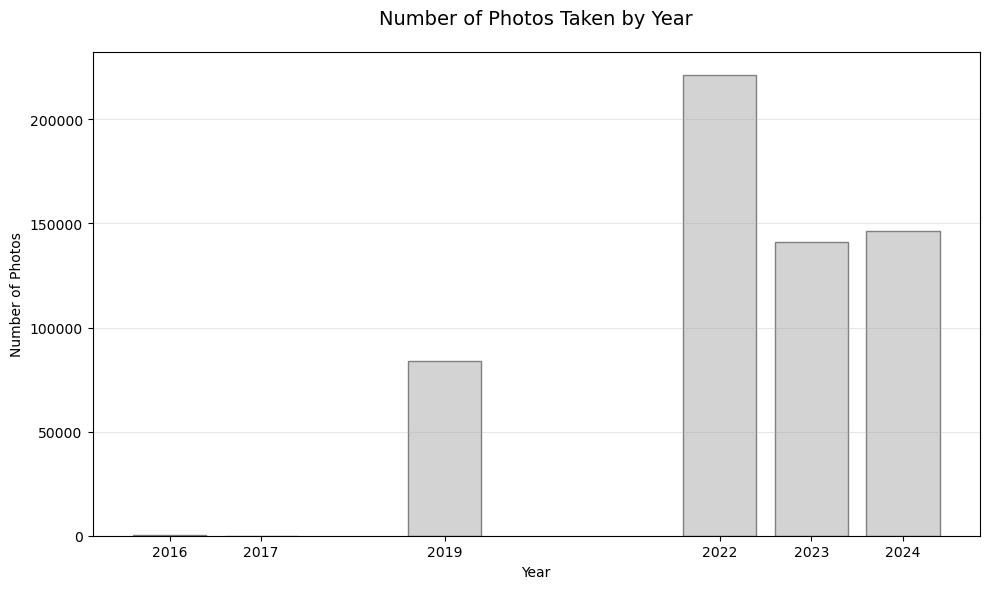

In [12]:
#Extract year from the captured_datetime column
panos['year'] = panos['captured_datetime'].dt.year

#Group by year and count the number of photos
photos_by_year = panos.groupby('year').size().reset_index(name='photo_count')

#Plot the data
plt.figure(figsize=(10, 6))
plt.bar(photos_by_year['year'], photos_by_year['photo_count'], color='lightgrey', edgecolor='grey', align='center')
plt.xticks(photos_by_year['year'])  # Ensure one bin per year
plt.title('Number of Photos Taken by Year', pad=20, size=14)
plt.xlabel('Year')
plt.ylabel('Number of Photos')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

We can see that first Lima's images were taken on 2016, but most of them where taken during 2019 and from 2022-2024.

#### Spatial Join images and streets and aggregate by district

In [13]:
# Create a buffer around streets for intersection
edges = edges.reset_index() 
edges["id_calle"] = edges.index
edges["geometry_buffer"] = edges.geometry.buffer(7.5) 

edges= edges[["id_calle","length", "geometry", "geometry_buffer"]].copy()

In [14]:
# Spatial join with buffered geometry
join = gpd.sjoin(panos, edges.set_geometry("geometry_buffer"), how="inner", predicate="intersects")
conteo_fotos = join.groupby("index_right").size().reset_index(name="n_fotos")
conteo_fotos = conteo_fotos.rename(columns={"index_right": "id_calle"})

#Add count to edges and reset geometry to original
edges = edges.set_geometry("geometry") 
edges = edges.merge(conteo_fotos, on="id_calle", how="left")
edges["n_fotos"] = edges["n_fotos"].fillna(0).astype(int)

In [15]:
# Calculate average photo spacing (length/number of photos) for streets with photos
edges['avg_photo_spacing'] = edges.apply(
    lambda x: x['length'] / x['n_fotos'] if x['n_fotos'] > 0 else None, 
    axis=1
)

In [16]:
#Classify edges with at least 1 photo
edges["coverage"] = edges["n_fotos"] >= 1

#Intersect edges with districts
intersection = gpd.overlay(edges, districts, how="intersection")

#Count edges by district
summary = (
    intersection.groupby("DISTRITO")
    .agg(
        number_edges=("id_calle", "nunique"),
        edges_with_photos=("coverage", lambda x: x.sum())
    )
    .reset_index()
)

summary["coverage_pct"] = (
    summary["edges_with_photos"] / summary["number_edges"] * 100
).round(1)

#Add summary to districts GeoDataFrame
districts = districts.merge(summary, on="DISTRITO", how="left")
districts = districts.fillna({"number_edges": 0, "edges_with_photos": 0, "coverage_pct": 0})

In [17]:
districts.head()

,DISTRITO,geometry,number_edges,edges_with_photos,coverage_pct
0,SANTA MARIA DEL MAR,"MULTIPOLYGON (((306366.208 8627551.561, 306343...",311.0,0.0,0.0
1,CARABAYLLO,"POLYGON ((292694.032 8702727.141, 292787.165 8...",31433.0,2336.0,7.4
2,CIENEGUILLA,"POLYGON ((312087.491 8672864.902, 312295.761 8...",5809.0,0.0,0.0
3,LURIN,"POLYGON ((311489.563 8654655.233, 311654.285 8...",9709.0,0.0,0.0
4,PACHACAMAC,"POLYGON ((294488.495 8665906.09, 295220.133 86...",12473.0,6.0,0.0


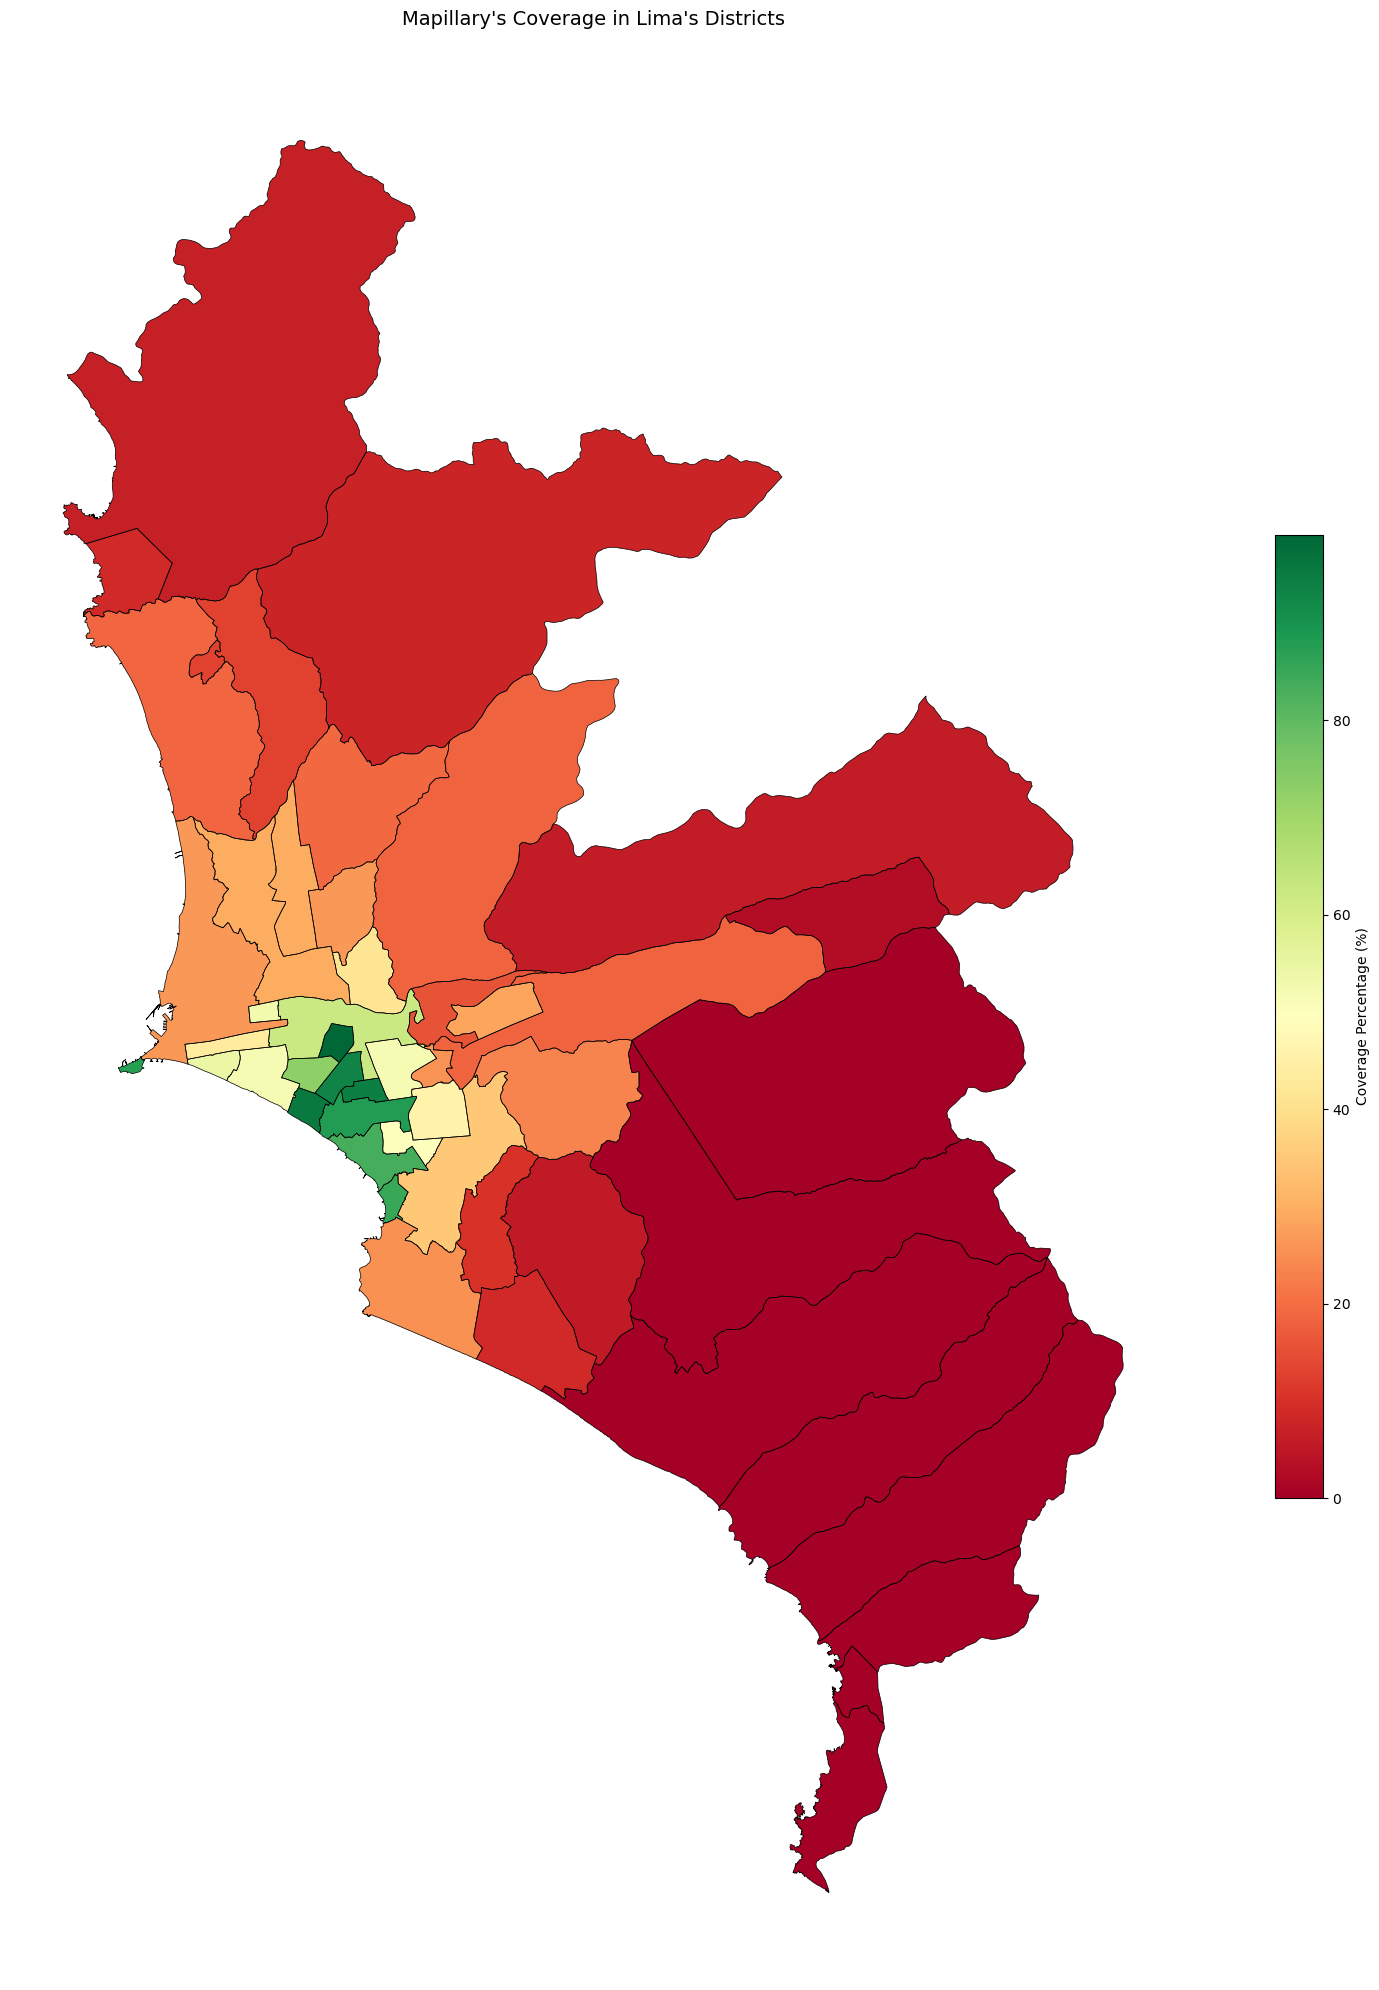

In [18]:
# Plot map
fig, ax = plt.subplots(figsize=(20, 20))

# Plot districts with coverage percentage
districts.plot(column='coverage_pct', 
               ax=ax,
               cmap='RdYlGn',  # rojo -> verde
               legend=True,
               legend_kwds={'label': 'Coverage Percentage (%)',
                            'orientation': 'vertical',  # Barra vertical
                            'shrink': 0.5})

# Añadir bordes negros
districts.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Remove axes
ax.set_axis_off()

# Add title
plt.title("Mapillary's Coverage in Lima's Districts", 
          pad=20, 
          size=14)

plt.tight_layout()
plt.show()


In [19]:
#Filter districts with coverage >= 50% and sort by coverage percentage
high_coverage = summary[summary['coverage_pct'] >= 50].sort_values('coverage_pct', ascending=False)

#Calculate average photo spacing for high coverage districts
avg_spacing = (intersection[intersection['DISTRITO'].isin(high_coverage['DISTRITO']) & 
                          (intersection['n_fotos'] > 0)]
              .groupby('DISTRITO')['avg_photo_spacing']
              .mean()
              .round(2))

#Add avg_photo_spacing to high_coverage
high_coverage = high_coverage.merge(avg_spacing.reset_index(), on='DISTRITO', how='left')

print("Districts with more than 50% coverage:")
print(high_coverage[['DISTRITO', 'coverage_pct', 'avg_photo_spacing']].to_string())

Districts with more than 50% coverage:
                      DISTRITO  coverage_pct  avg_photo_spacing
0                        BREÑA          99.1               1.09
1            MAGDALENA DEL MAR          95.5               7.60
2                        LINCE          94.2               8.96
3                  JESUS MARIA          93.1               7.76
4                   SAN ISIDRO          88.0               9.86
5                     LA PUNTA          87.1              15.04
6                     BARRANCO          84.9              13.88
7                   MIRAFLORES          83.4               7.99
8                 PUEBLO LIBRE          72.8              12.40
9                         LIMA          62.1              18.22
10                    LA PERLA          54.2              25.78
11  CARMEN DE LA LEGUA REYNOSO          52.7              19.55
12                  SAN MIGUEL          52.0              21.17
13                 LA VICTORIA          51.9              14.20
1

In [20]:
#Filter streets of high coverage districts
high_coverage_districts = high_coverage['DISTRITO'].tolist()
high_coverage_streets = intersection[intersection['DISTRITO'].isin(high_coverage_districts)].copy()

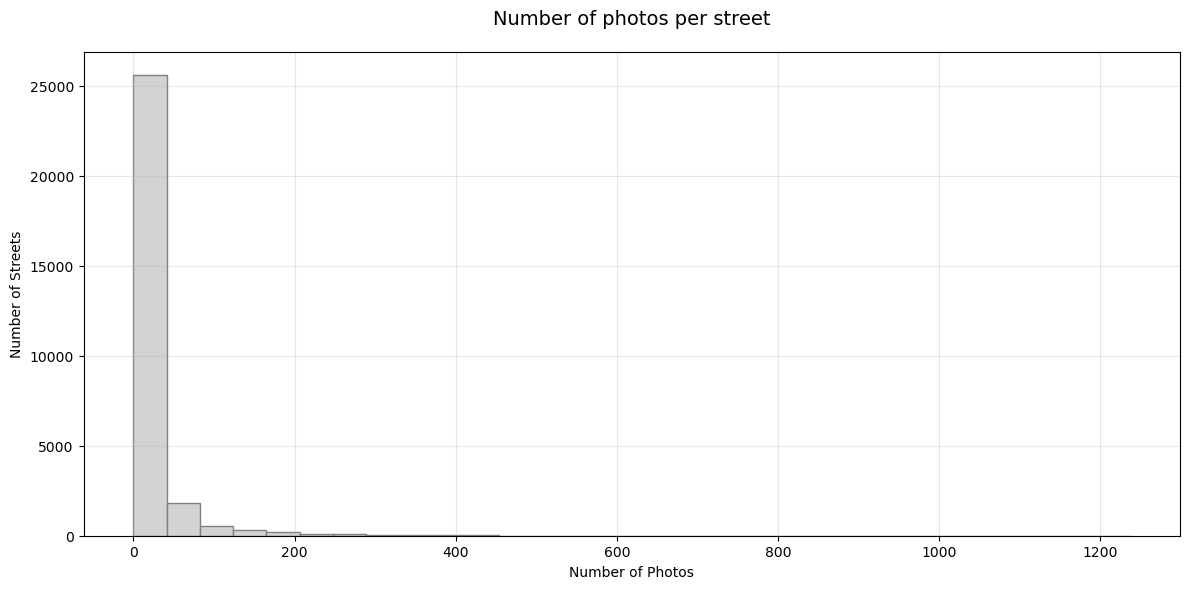

In [21]:
plt.figure(figsize=(12, 6))

#Create histogram on 'n_fotos' (number of photos per street)
plt.hist(high_coverage_streets['n_fotos'], bins=30, color='lightgrey', edgecolor='grey')

plt.title('Number of photos per street', pad=20, size=14)
plt.xlabel('Number of Photos')
plt.ylabel('Number of Streets')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

As distribution is highly skewed, I'll first filter those values above a threshold of the quantile 0.90 and then apply Natural Breaks (Jenks) to define categories for mapping. To make map bins more intuitive, they will be rounded to base 5

In [22]:
#Rounding values
BASE = 5        
LOWER_MIN = 1    
K = 3      

In [23]:
def round_nice_edges(edges, base=10, lower_min=1, upper_fix=None):
    e = np.array(edges, dtype=float).copy()
    e[0] = lower_min

    if len(e) > 2:
        mids = e[1:-1]
        mids = np.round(mids / base) * base
        e[1:-1] = mids

    if upper_fix is not None:
        e[-1] = upper_fix
    else:
        e[-1] = np.ceil(e[-1] / base) * base

    e = e.astype(int)
    for i in range(1, len(e)):
        if e[i] <= e[i-1]:
            e[i] = e[i-1] + 1
    return np.unique(e)

In [24]:
#Rounding values
BASE = 5        
LOWER_MIN = 1    
K = 3      

In [25]:
#Separate 0 values and others
mask_zero = high_coverage_streets['n_fotos'] == 0
mask_pos  = high_coverage_streets['n_fotos'] > 0

#Filter by threshold
threshold = high_coverage_streets.loc[mask_pos, 'n_fotos'].quantile(0.90)
rounded_threshold = int(np.ceil(threshold / BASE) * BASE)  # ej. 187 -> 190 si BASE=10

#Define outliers
mask_outlier   = high_coverage_streets['n_fotos'] > rounded_threshold
mask_for_jenks = mask_pos & ~mask_outlier

#Apply Jenks to only valid n_fotos (>0)
valores_jenks = high_coverage_streets.loc[mask_for_jenks, 'n_fotos'].astype(float)
nb = mc.NaturalBreaks(valores_jenks, k=K)

#Add raw values
edges_raw = np.concatenate(([LOWER_MIN], nb.bins[:-1], [rounded_threshold])).astype(float)
#Add rounded values
edges_nice = round_nice_edges(edges_raw, base=BASE, lower_min=LOWER_MIN, upper_fix=rounded_threshold)

#Make labels
def make_labels(edges):
    return [f"{int(lo)}-{int(hi)} images" for lo, hi in zip(edges[:-1], edges[1:])]

jenks_labels = make_labels(edges_nice)

#Assign classes
high_coverage_streets.loc[mask_zero, 'class'] = '0 images'

#Assign Jenks classes
high_coverage_streets.loc[mask_for_jenks, 'class'] = pd.cut(
    high_coverage_streets.loc[mask_for_jenks, 'n_fotos'],
    bins=edges_nice,
    labels=jenks_labels,
    include_lowest=True,
    right=True
)

high_coverage_streets.loc[mask_outlier, 'class'] = f">{rounded_threshold} images"


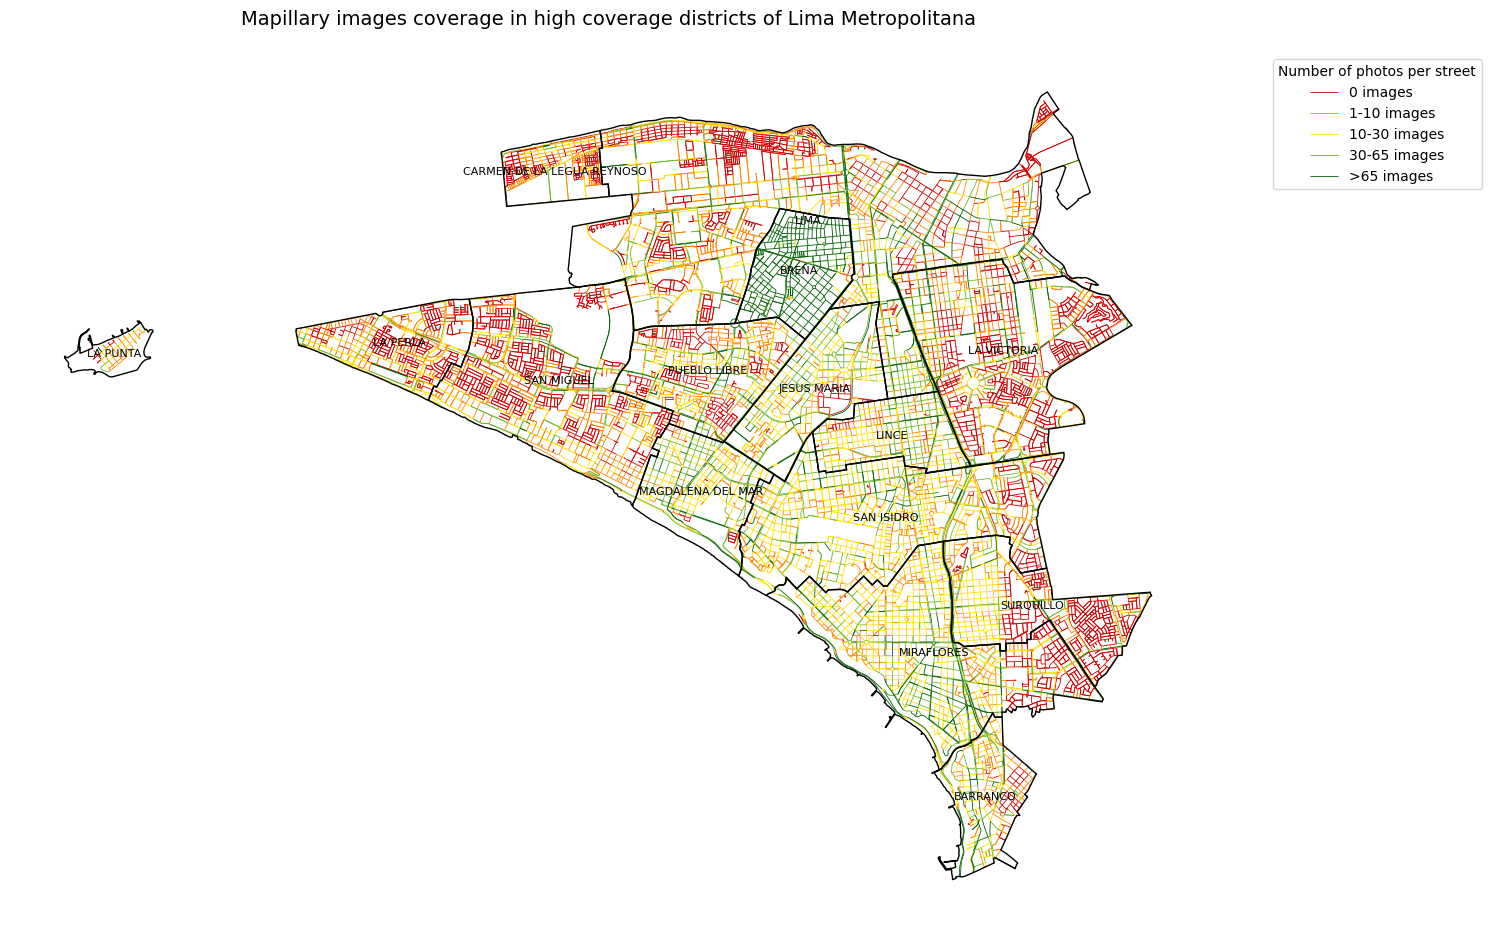

p90 (raw): 62.00  |  p90 (rounded to base 5): 65
Rounded edges: [ 1 10 30 65]
class
1-10 images     9455
0 images        9121
10-30 images    5853
30-65 images    2522
>65 images      1853
Name: count, dtype: int64


In [26]:
#Legend
colors = ["#D10000"]  # 0 imágenes
palette_jenks = ["#ff8400", "#ffe100", "#6ab82c", "#006400"]
colors += palette_jenks[:len(jenks_labels)]
colors += ["#006103"]  # outliers

legend_labels = ['0 images'] + jenks_labels + [f">{rounded_threshold} images"]

#Plot
fig, ax = plt.subplots(figsize=(15, 15))
for cat, color in zip(legend_labels, colors):
    mask_cat = high_coverage_streets['class'] == cat
    if mask_cat.any():
        high_coverage_streets[mask_cat].plot(ax=ax, color=color, label=cat, linewidth=.60)

districts[districts['DISTRITO'].isin(high_coverage_districts)].boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_axis_off()

#Add labels
for idx, row in districts[districts['DISTRITO'].isin(high_coverage_districts)].iterrows():
    ax.annotate(text=row['DISTRITO'], 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center',
                va='center',
                fontsize=8)

plt.title('Mapillary images coverage in high coverage districts of Lima Metropolitana', pad=20, size=14)
plt.legend(title='Number of photos per street', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Info
print(f"p90 (raw): {threshold:.2f}  |  p90 (rounded to base {BASE}): {rounded_threshold}")
print("Rounded edges:", edges_nice)
print(high_coverage_streets['class'].value_counts(dropna=False))


### Zoom to Breña

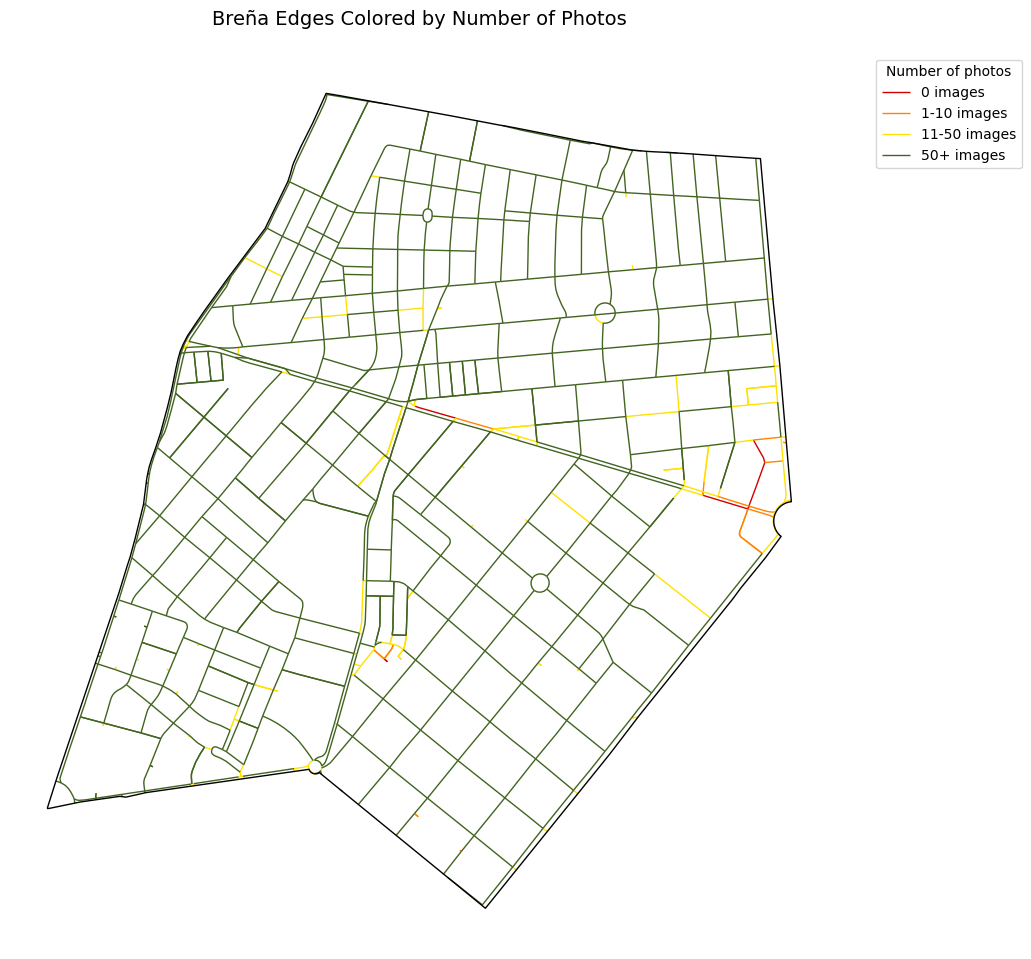

In [27]:
#Filter edges for Breña
brena_edges = intersection[intersection['DISTRITO'] == 'BREÑA'].copy()

#Create categories
brena_edges['class'] = pd.cut(
    brena_edges['n_fotos'], 
    bins=[-float('inf'), 0, 10, 50, float('inf')], 
    labels=['0 images', '1-10 images', '11-50 images', '50+ images']
)

#Plot the edges
fig, ax = plt.subplots(figsize=(10, 10))

# Define colors for categories
colors = ["#D10000", "#ff8400", "#ffe100", "#426420"]
legend_labels = ['0 images', '1-10 images', '11-50 images', '50+ images']

#Plot edges by category
for cat, color in zip(legend_labels, colors):
    mask = brena_edges['class'] == cat
    brena_edges[mask].plot(ax=ax, color=color, label=cat, linewidth=1)

#Add Breña's polygon
districts[districts['DISTRITO'] == 'BREÑA'].boundary.plot(ax=ax, color='black', linewidth=1)

#Add title and legend
plt.title('Breña Edges Colored by Number of Photos', pad=20, size=14)
plt.legend(title='Number of photos', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_axis_off()
plt.tight_layout()
plt.show()